# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Connection to your drive

In [1]:
DATA_DIR =  './pizzaGANdata'

## Useful libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
# from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

cuda:0
Wed Jan 25 09:11:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P5    30W /  N/A |    624MiB /  5946MiB |     63%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

## Managing data

### Read data and build the train and test dataset

In [23]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'imageLabels.txt'))[:2000]
x_all = np.arange(y_all.shape[0])

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_train.shape)
print(y_test.shape)

print(x_train.shape)
print(x_test.shape)

(1600, 13)
(400, 13)
(1600,)
(400,)


### Display one sample image

00046.jpg


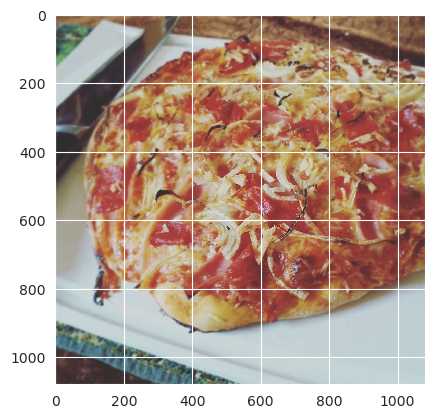

In [24]:
idx = 45

img_name = "{:05d}.jpg".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

In [25]:
train_data_path=os.path.join(DATA_DIR, '')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:05d}.jpg".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((500, 500))))

  np.savez_compressed(os.path.join(train_data_path,'img_data.npz'), img_data=np.array(img_all))

100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.91it/s]


### Dataset class

In [26]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path, img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:05d}.jpg".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [27]:
batch_size = 5

input_size = 500

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize((input_size, input_size)),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}


img_data=np.array(img_all)

# TRAIN DATA
train_data_path=img_path = os.path.join(DATA_DIR, 'images')
img_data_train = img_data[x_train,:,:,:]

train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

# TEST DATA
test_data_path=img_path = os.path.join(DATA_DIR, 'images')
img_data_test = img_data[x_test,:,:,:]

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, img_data=img_data_train, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

### Visualize data loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


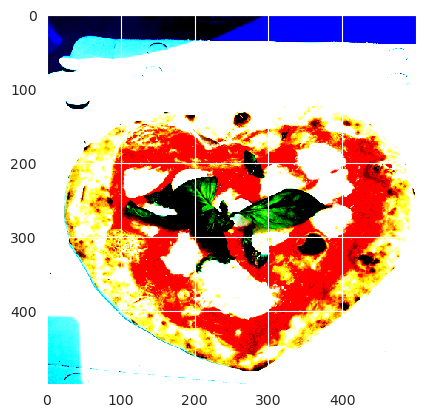

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 500, 500])


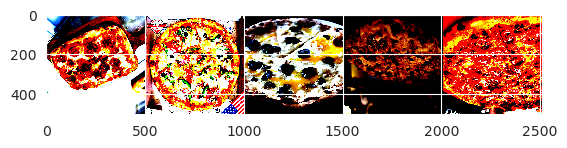

In [28]:
# Show dataset sample
x,y = test_set_raw[46]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


## Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


In [29]:
nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

# Name of the network
tag = "efficientNet"

# Read the last learned network (if stored)
if (os.path.exists(os.path.join("networks", 'network_real_{:s}.pth'.format(tag)))):
    print('Loading from file')
    network = torch.load(os.path.join("networks", 'network_real_{:s}.pth'.format(tag)))


Loading from file


# Learning

Generic function for multi-label learning.

In [30]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import copy
import random


def train_model_multilabel(model, nlabel, trainloader, criterion, optimizer, scheduler, num_epochs=5):
  # list for saving accuracies
  for epoch in range(num_epochs): # on va iterer sur toutes les données num_epochs fois
      print("Epoch {}".format(epoch))
      model.train()

      for inputs, targets in trainloader: # on itère sur les données par batch de batch_size (= 25)
          inputs, targets = inputs.cuda(),targets.cuda() # 25x3x224x224 et 25x10

          predictions = model(inputs)    ## on les fait rentrer dans le réseau
          targets = targets.to(torch.float) # FloatTensor needed

          loss = criterion(predictions,targets)    ## on compare la sortie courante à la sortie voulue
          optimizer.zero_grad() ## supprime les gradients courants
          loss.backward() ## le gradient -- la magie par rapport à comment c'était long en cours :-)
          optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

          if random.randint(0,90)==0:
              print("\tloss=",loss) ## on affiche pour valider que ça diverge pas

      # Learning step

  return model

In [18]:
# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)

optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Learning 

max_epoch = 10 # initial 20
network = train_model_multilabel(network, nlabel, train_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(network, os.path.join("networks", 'network_real_{:s}.pth'.format(tag)))


Epoch 0


KeyboardInterrupt: 

### Final evaluation

An example of performance computation.

Again, the problem is multi-label prediction, not classification: performance metrics may be different (make a little search to find relevant ones).

In [50]:
def model_evaluation(network, nb_labels, dataloader, labels=None, display=0):

  # set the model to evaluation mode
  network.eval()

  # create the vectors necessary for the KPI
  perf_label_test = np.zeros((1,nb_labels))
  all_eval_pred = np.zeros(shape=(0,nb_labels))
  all_eval_targets = np.zeros((0,nb_labels))


  # tell not to reserve memory space for gradients (much faster)
  with torch.no_grad():
      for inputs, targets in tqdm(dataloader, ncols=80):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # Compute outputs
          outputs = network(inputs)
          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          # Compute the predictions
          pred = (outputs_np > 0)

          # Concatenate pred and targets to calculate the classification report
          all_eval_pred = np.concatenate((all_eval_pred, pred))
          all_eval_targets = np.concatenate((all_eval_targets, targets_np))
          # update the performance
          perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report


  # Calculate KPI
  perf_label_test = perf_label_test / len(dataloader.dataset)
  metrics_report = classification_report(all_eval_targets, all_eval_pred, target_names=labels)

  # Prints the classification report and the performance (per label)
  if display==1:
    print("\nPerformance per label :",perf_label_test)
    print("Mean of performance :",sum(perf_label_test[0])/len(perf_label_test[0]))
    print(metrics_report)

  return perf_label_test, metrics_report

In [51]:
# set the model to evaluation mode
network.eval()

# create the per
perf_label_test = np.zeros((1,nlabel))

# accuracy_score from sklearn.metrics

# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)

        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # compute the predictions
        pred = (outputs_np > 0)

        # update the performance
        perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

# Prints the performance (per label)

oa_test = perf_label_test / len(test_dataloader.dataset)
print(oa_test)

print(sum(oa_test[0])/len(oa_test[0]))

labels_name = ["Pepperoni", "Bacon", "Mushrooms", "Onions",
              "Peppers", "Black olives", "Tomatoes", "Spinach", "Fresh basil",
               "Arugula", "Broccoli", "Corn", "Pineapple"]

model_evaluation(network, len(labels_name), test_dataloader, labels=labels_name, display=1)

100%|███████████████████████████████████████████| 80/80 [00:14<00:00,  5.54it/s]


[[0.58   0.9075 0.68   0.7725 0.775  0.745  0.645  0.7825 0.615  0.9175
  0.975  0.915  0.92  ]]
0.7869230769230768


100%|███████████████████████████████████████████| 80/80 [00:14<00:00,  5.51it/s]


Performance per label : [[0.58   0.9075 0.68   0.7725 0.775  0.745  0.645  0.7825 0.615  0.9175
  0.975  0.915  0.92  ]]
Mean of performance : 0.7869230769230768
              precision    recall  f1-score   support

   Pepperoni       0.19      0.27      0.22        88
       Bacon       0.00      0.00      0.00        12
   Mushrooms       0.07      0.11      0.09        54
      Onions       0.12      0.20      0.15        40
     Peppers       0.22      0.33      0.26        48
Black olives       0.08      0.15      0.11        41
    Tomatoes       0.26      0.36      0.30        85
     Spinach       0.06      0.17      0.08        24
 Fresh basil       0.20      0.31      0.25        80
     Arugula       0.05      0.06      0.06        16
    Broccoli       0.00      0.00      0.00         4
        Corn       0.00      0.00      0.00         8
   Pineapple       0.03      0.25      0.06         4

   micro avg       0.14      0.24      0.18       504
   macro avg       0.10  

(array([[0.58  , 0.9075, 0.68  , 0.7725, 0.775 , 0.745 , 0.645 , 0.7825,
         0.615 , 0.9175, 0.975 , 0.915 , 0.92  ]]),
 '              precision    recall  f1-score   support\n\n   Pepperoni       0.19      0.27      0.22        88\n       Bacon       0.00      0.00      0.00        12\n   Mushrooms       0.07      0.11      0.09        54\n      Onions       0.12      0.20      0.15        40\n     Peppers       0.22      0.33      0.26        48\nBlack olives       0.08      0.15      0.11        41\n    Tomatoes       0.26      0.36      0.30        85\n     Spinach       0.06      0.17      0.08        24\n Fresh basil       0.20      0.31      0.25        80\n     Arugula       0.05      0.06      0.06        16\n    Broccoli       0.00      0.00      0.00         4\n        Corn       0.00      0.00      0.00         8\n   Pineapple       0.03      0.25      0.06         4\n\n   micro avg       0.14      0.24      0.18       504\n   macro avg       0.10      0.17      0.12 

# Visualization

In [2]:
labels_name = ["Pepperoni", "Bacon", "Mushrooms", "Onions",
              "Peppers", "Black olives", "Tomatoes", "Spinach", "Fresh basil",
               "Arugula", "Broccoli", "Corn", "Pineapple"]

def show_result_on_random_batch(labels_name):
    def label_in_image(vector):
        lbl = []

        for i in range(len(vector)):
            if vector[i]:
                lbl.append(labels_name[i])
        return lbl


    with torch.no_grad():
        r = random.randint(0, len(iter(test_dataloader)))
        print(f"Batch n°{r}")
        for i in range(r):
            inputs, targets = next(iter(test_dataloader))

        inputs_cuda = inputs.to(device)

        # compute outputs
        outputs = network(inputs_cuda)
        outputs_np = outputs.cpu().detach().numpy()

        for idx in range(batch_size):
            out = torchvision.utils.make_grid(inputs[idx, :, :, :])
            plt.imshow(out.permute(1, 2, 0))
            plt.show()


            print("IA finds", ', '.join(label_in_image(outputs_np[idx, :] > 0)))
            print("Correct answer is", ', '.join(label_in_image(targets[idx, :] == 1)))

show_result_on_random_batch(labels_name)

NameError: name 'torch' is not defined